In [310]:
from typing import Union

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    accuracy_score,
    classification_report,
    confusion_matrix,
)
from sklearn.model_selection import train_test_split

## Load Iris Dataset

In [311]:
from sklearn.datasets import load_iris

iris = load_iris()
df = pd.DataFrame(iris["data"], columns=iris["feature_names"])
df["y"] = iris["target"]
df["y"] = df["y"].map(dict(enumerate(iris.target_names)))

# Keep only rows where y is `Virginica` or `Versicolor`
df = df[df["y"].isin(["virginica", "versicolor"])]

# Keep only `sepal length (cm)` and `sepal width (cm)` columns

columns_to_keep = ["sepal length (cm)", "sepal width (cm)"]
df = df.loc[:, columns_to_keep + ["y"]]

In [312]:
print(f"Number of instances: {len(df)}")

Number of instances: 100


## Joint Plot

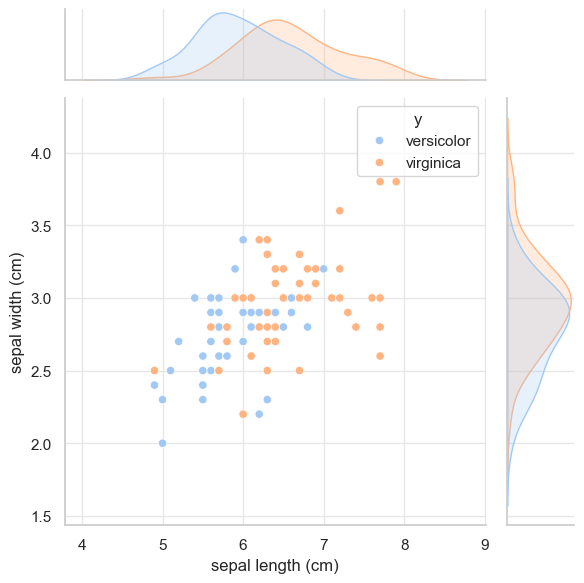

In [313]:
sns.set(style="whitegrid", palette="pastel", rc={"grid.color": ".9"})

sns.jointplot(df, x="sepal length (cm)", y="sepal width (cm)", hue="y")

sns.despine()

plt.tight_layout()
plt.show()

## Split Train/Test

In [314]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop("y", axis=1), df["y"], test_size=0.3, random_state=42, stratify=df["y"]
)

---

## LDA/QDA Training

In [315]:
from sklearn.discriminant_analysis import (
    LinearDiscriminantAnalysis,
    QuadraticDiscriminantAnalysis,
)

In [316]:
def plot_confusion_matrix(
    y_true: Union[pd.Series, np.ndarray],
    y_pred: Union[pd.Series, np.ndarray],
):
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm, display_labels=iris.target_names[1:]
    )
    disp.plot(cmap="Blues")
    plt.grid(False)
    plt.gca().set_frame_on(False)
    plt.show()


def display_decision_boundary(
    model, X: pd.DataFrame, y: pd.Series, xlabel: str, ylabel: str
):
    """Display the decision boundary of a model.

    Parameters
    ----------
    model : _type_
        Model to display the decision boundary of.
    X : pd.DataFrame
        Dataframe containing the features.
    y : pd.Series
        Series containing the target.
    xlabel : str
        Feature to display on the x-axis.
    ylabel : str
        Fetaure to display on the y-axis.
    """
    # Plot the decision boundary
    _ = DecisionBoundaryDisplay.from_estimator(
        model,
        X,
        response_method="predict",
        xlabel=xlabel,
        ylabel=ylabel,
        alpha=0.5,
    )

    # Add scatterplot
    sns.scatterplot(data=X, x=xlabel, y=ylabel, hue=y, alpha=0.5)

    plt.show()


In [317]:
# This dictionary is needed to build a comparative DataFrame between models
models_accuracy_dict = {
    "Model": ["LDA", "QDA", "RDA(0.25)", "RDA(0.5)", "RDA(0.75)"],
    "Accuracy": [],
}

### LDA

In [318]:
lda = LinearDiscriminantAnalysis()

lda.fit(X_train, y_train)

y_pred_lda = lda.predict(X_test)


              precision    recall  f1-score   support

  versicolor       0.65      0.87      0.74        15
   virginica       0.80      0.53      0.64        15

    accuracy                           0.70        30
   macro avg       0.73      0.70      0.69        30
weighted avg       0.72      0.70      0.69        30



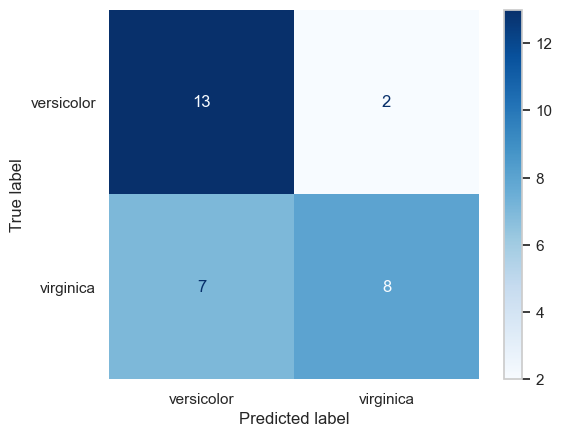

In [ ]:
print(classification_report(y_test, y_pred_lda))
plot_confusion_matrix(y_test, y_pred_lda)
models_accuracy_dict["Accuracy"].append(accuracy_score(y_test, y_pred_lda))

---

### QDA

In [320]:
qda = QuadraticDiscriminantAnalysis()

qda.fit(X_train, y_train)

y_pred_qda = qda.predict(X_test)

              precision    recall  f1-score   support

  versicolor       0.63      0.80      0.71        15
   virginica       0.73      0.53      0.62        15

    accuracy                           0.67        30
   macro avg       0.68      0.67      0.66        30
weighted avg       0.68      0.67      0.66        30



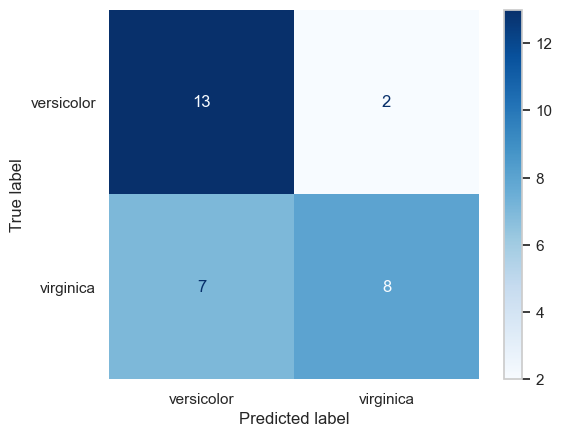

In [321]:
print(classification_report(y_test, y_pred_qda))
plot_confusion_matrix(y_test, y_pred_lda)
models_accuracy_dict["Accuracy"].append(accuracy_score(y_test, y_pred_qda))

---

### RDA

Primero se responderá a la siguiente pregunta: ¿Por qué no vamos a emplear un RDA(0) o RDA(1)? 

RDA introduce el parámetro de regularización `shrinkage`, que combina las ventajas de LDA y QDA. LDA asume que la varianza de las clases es común, mientras que QDA asume lo contrario, es decir, en el caso de LDA, la forma de la nube de puntos es similar para la distribución de ambas clases, mientras que las nubes de puntos para cada clase que asume QDA pueden tener formas distintas. La idea de `shrinkage` es “encoger” la matriz de covarianza específica de cada clase hacia una matriz común.

$\tilde{\Sigma}_k = (1-\alpha)\Sigma_k + \alpha\Sigma$

donde $\Sigma_k$ es la covarianza de la clase k (Asunción de QDA), $\Sigma$ es la covarianza global (Asunción de LDA) y $\alpha \in [0,1]$ es el parámetro de regularización de `shrinkage`.

Por lo tanto, si $\alpha$ = 0, entonces no se está aplicando la regularización, por lo que se usan las matrices de covarianza $\Sigma_k$ originales; y esto equivaldría a QDA. Sin embargo, si $\alpha = 1$, se usa la matriz de covarianza común $\Sigma$ para todas las clases; y esto equivale a LDA.

Utilizar $\alpha$ entre 0 y 1 (0.25, 0.5, 0.75) da como resultado la combinación entre LDA y QDA

In [322]:
shrinkage = [0.25, 0.5, 0.75]
rda_models = {}
for shr in shrinkage:
    rda = LinearDiscriminantAnalysis(solver="lsqr", shrinkage=shr)
    rda.fit(X_train, y_train)
    y_pred = rda.predict(X_test)
    rda_models[shr] = {"model": rda, "preds": y_pred}


In [323]:
rda_models

{0.25: {'model': LinearDiscriminantAnalysis(shrinkage=0.25, solver='lsqr'),
  'preds': array(['versicolor', 'versicolor', 'versicolor', 'versicolor',
         'versicolor', 'versicolor', 'virginica', 'virginica', 'virginica',
         'versicolor', 'versicolor', 'virginica', 'versicolor',
         'versicolor', 'versicolor', 'virginica', 'versicolor',
         'versicolor', 'virginica', 'versicolor', 'versicolor',
         'versicolor', 'virginica', 'versicolor', 'virginica', 'versicolor',
         'versicolor', 'virginica', 'versicolor', 'versicolor'],
        dtype='<U10')},
 0.5: {'model': LinearDiscriminantAnalysis(shrinkage=0.5, solver='lsqr'),
  'preds': array(['versicolor', 'versicolor', 'versicolor', 'versicolor',
         'versicolor', 'versicolor', 'virginica', 'virginica', 'virginica',
         'versicolor', 'versicolor', 'virginica', 'versicolor',
         'versicolor', 'versicolor', 'virginica', 'versicolor',
         'versicolor', 'virginica', 'versicolor', 'versicolor',


#### RDA(0.25)

              precision    recall  f1-score   support

  versicolor       0.67      0.93      0.78        15
   virginica       0.89      0.53      0.67        15

    accuracy                           0.73        30
   macro avg       0.78      0.73      0.72        30
weighted avg       0.78      0.73      0.72        30



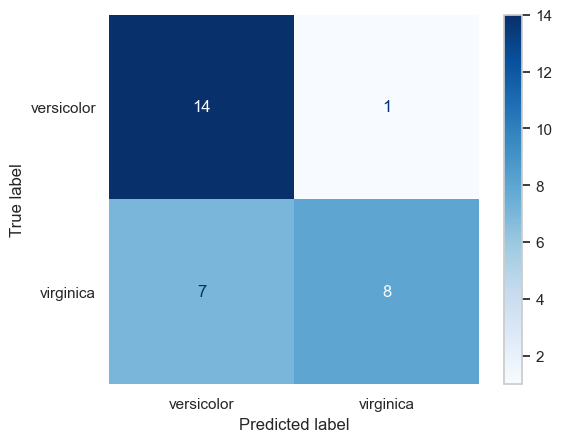

In [324]:
print(classification_report(y_test, rda_models[0.25]["preds"]))
plot_confusion_matrix(y_test, rda_models[0.25]["preds"])
models_accuracy_dict["Accuracy"].append(accuracy_score(y_test, rda_models[0.25]["preds"]))

#### RDA(0.5)

              precision    recall  f1-score   support

  versicolor       0.67      0.93      0.78        15
   virginica       0.89      0.53      0.67        15

    accuracy                           0.73        30
   macro avg       0.78      0.73      0.72        30
weighted avg       0.78      0.73      0.72        30



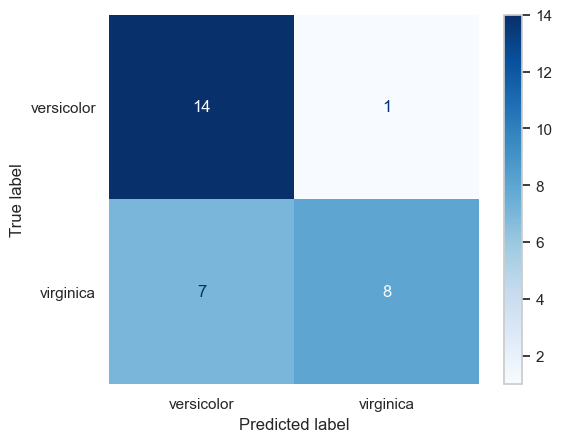

In [325]:
print(classification_report(y_test, rda_models[0.5]["preds"]))
plot_confusion_matrix(y_test, rda_models[0.5]["preds"])
models_accuracy_dict["Accuracy"].append(accuracy_score(y_test, rda_models[0.5]["preds"]))

#### RDA(0.75)

              precision    recall  f1-score   support

  versicolor       0.67      0.93      0.78        15
   virginica       0.89      0.53      0.67        15

    accuracy                           0.73        30
   macro avg       0.78      0.73      0.72        30
weighted avg       0.78      0.73      0.72        30



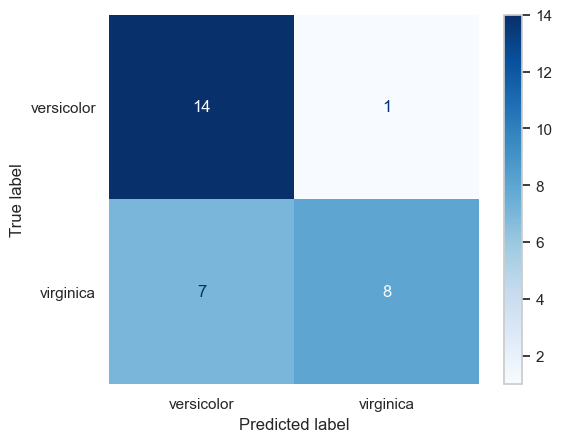

In [326]:
print(classification_report(y_test, rda_models[0.75]["preds"]))
plot_confusion_matrix(y_test, rda_models[0.75]["preds"])
models_accuracy_dict["Accuracy"].append(accuracy_score(y_test, rda_models[0.75]["preds"]))

## Model Accuracy Comparision

In [328]:
pd.DataFrame(models_accuracy_dict)

,Model,Accuracy
0,LDA,0.700000
1,QDA,0.666667
2,RDA(0.25),0.733333
3,RDA(0.5),0.733333
4,RDA(0.75),0.733333


Cualquiera de las tres variaciones de **RDA** obtuvieron el mismo Accuracy. **RDA** ofrece un 4% más de Accuracy que **LDA** y un 9.5% más que **QDA**. **QDA** es el método con menor Accuracy

## Display the Decision Boundary

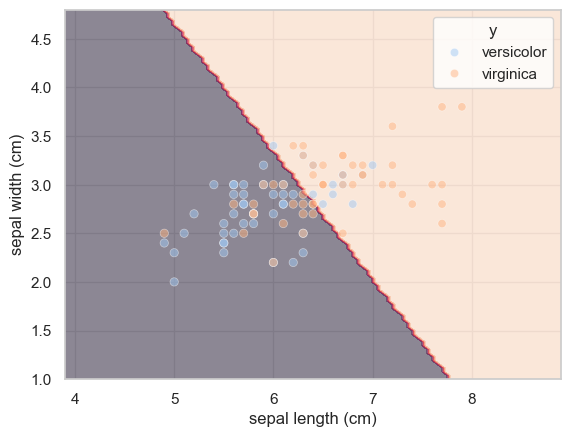

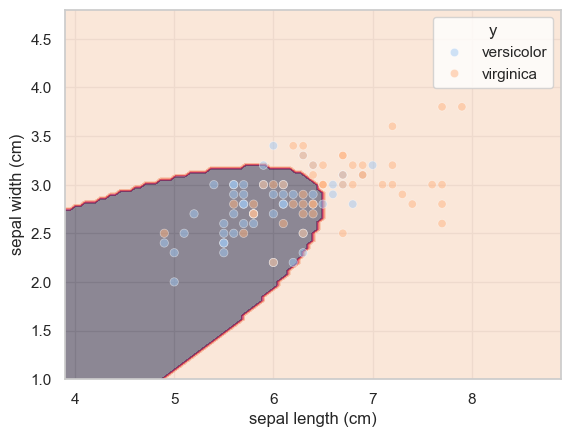

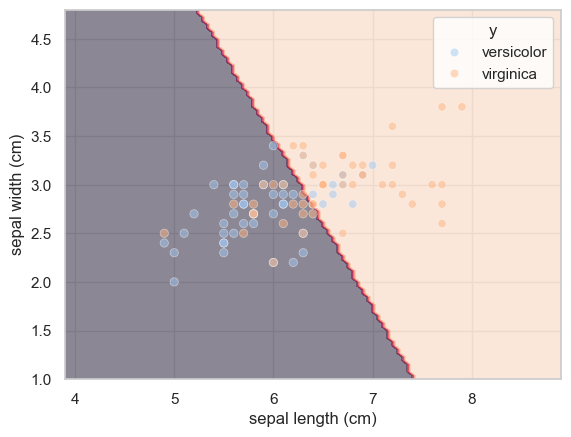

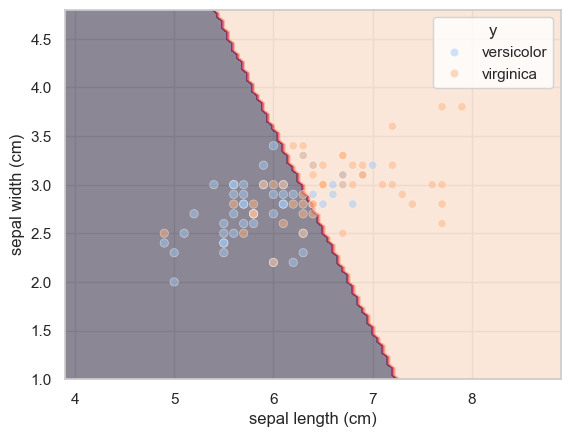

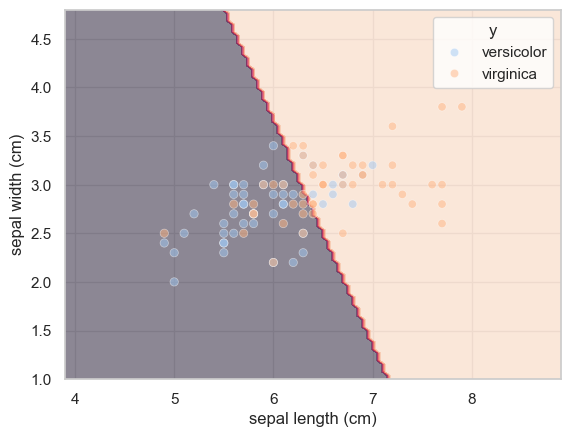

In [332]:
display_decision_boundary(
    lda, df.drop("y", axis=1), df["y"], "sepal length (cm)", "sepal width (cm)"
)
display_decision_boundary(
    qda, df.drop("y", axis=1), df["y"], "sepal length (cm)", "sepal width (cm)"
)
display_decision_boundary(
    rda_models[0.25]["model"], df.drop("y", axis=1), df["y"], "sepal length (cm)", "sepal width (cm)"
)
display_decision_boundary(
    rda_models[0.5]["model"], df.drop("y", axis=1), df["y"], "sepal length (cm)", "sepal width (cm)"
)
display_decision_boundary(
    rda_models[0.75]["model"], df.drop("y", axis=1), df["y"], "sepal length (cm)", "sepal width (cm)"
)